In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
pd.options.mode.chained_assignment = None  # default='warn'

## Importation des csv

In [2]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

Dans le dataset des reviews on transforme la colonne review_comment_title et review_comment_message pour obtenir la longueur du message et du titre

In [3]:
from functions import *

df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))

df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.groupby(["order_id","review_score"]).agg({"length_comment_title":"max","length_comment_message":"max","review_answer_timestamp":"first"})
df_olist_order_reviews_dataset.reset_index(inplace=True)

In [4]:
# Convertir la colonne 'date' en un objet de type datetime
df_olist_order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews_dataset['review_answer_timestamp'])

# Groupby order_id et trouver l'index de la date la plus récente pour chaque order_id
latest_dates = df_olist_order_reviews_dataset.groupby('order_id').review_answer_timestamp.idxmax()

# Utilisez l'index trouvé pour sélectionner les lignes avec les dates les plus récentes
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.loc[latest_dates]

Dans le dataset des produits on remplace les nan de la colonne product_photos_qty par 0.

On remplace les nan de la colonne product_category_name par unknown.

On remplace les nan de la colonne product_description_lenght par 0.

On drop la colonne product_name_lenght.

In [5]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)


In [6]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

Dans le dataset des items on groupe par la colonne order_id . Pour obtenir le produit et le vendeur le plus frequent de la commande, le nombre de produit dans la commande et la somme des prix et cout de transport

In [7]:
def get_mode(x):
    return x.mode().iloc[0]
    
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id"]).agg({"product_id":get_mode,"seller_id":get_mode,"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=["product_most_frequent","most_frequent_seller",'nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

Regroupement par order_id dans le dataset payments pour que les order_id soit unique

In [8]:
df_olist_order_payments_dataset = df_olist_order_payments_dataset.groupby(["order_id"]).agg({"payment_type":get_mode,"payment_sequential":"count","payment_installments":"max","payment_value":"sum"})
df_olist_order_payments_dataset.rename(columns={"payment_type":"payment_type_most_frequent"},inplace=True)
df_olist_order_payments_dataset.reset_index(inplace=True)

## Merge des datasets

In [9]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")
df_merge = df_merge.merge(df_product,how="left",right_on='product_id',left_on="product_most_frequent")
df_merge = df_merge.merge(df_olist_sellers_dataset,how="outer",left_on="most_frequent_seller",right_on="seller_id")

Visualisation des valeurs manquantes

<AxesSubplot: >

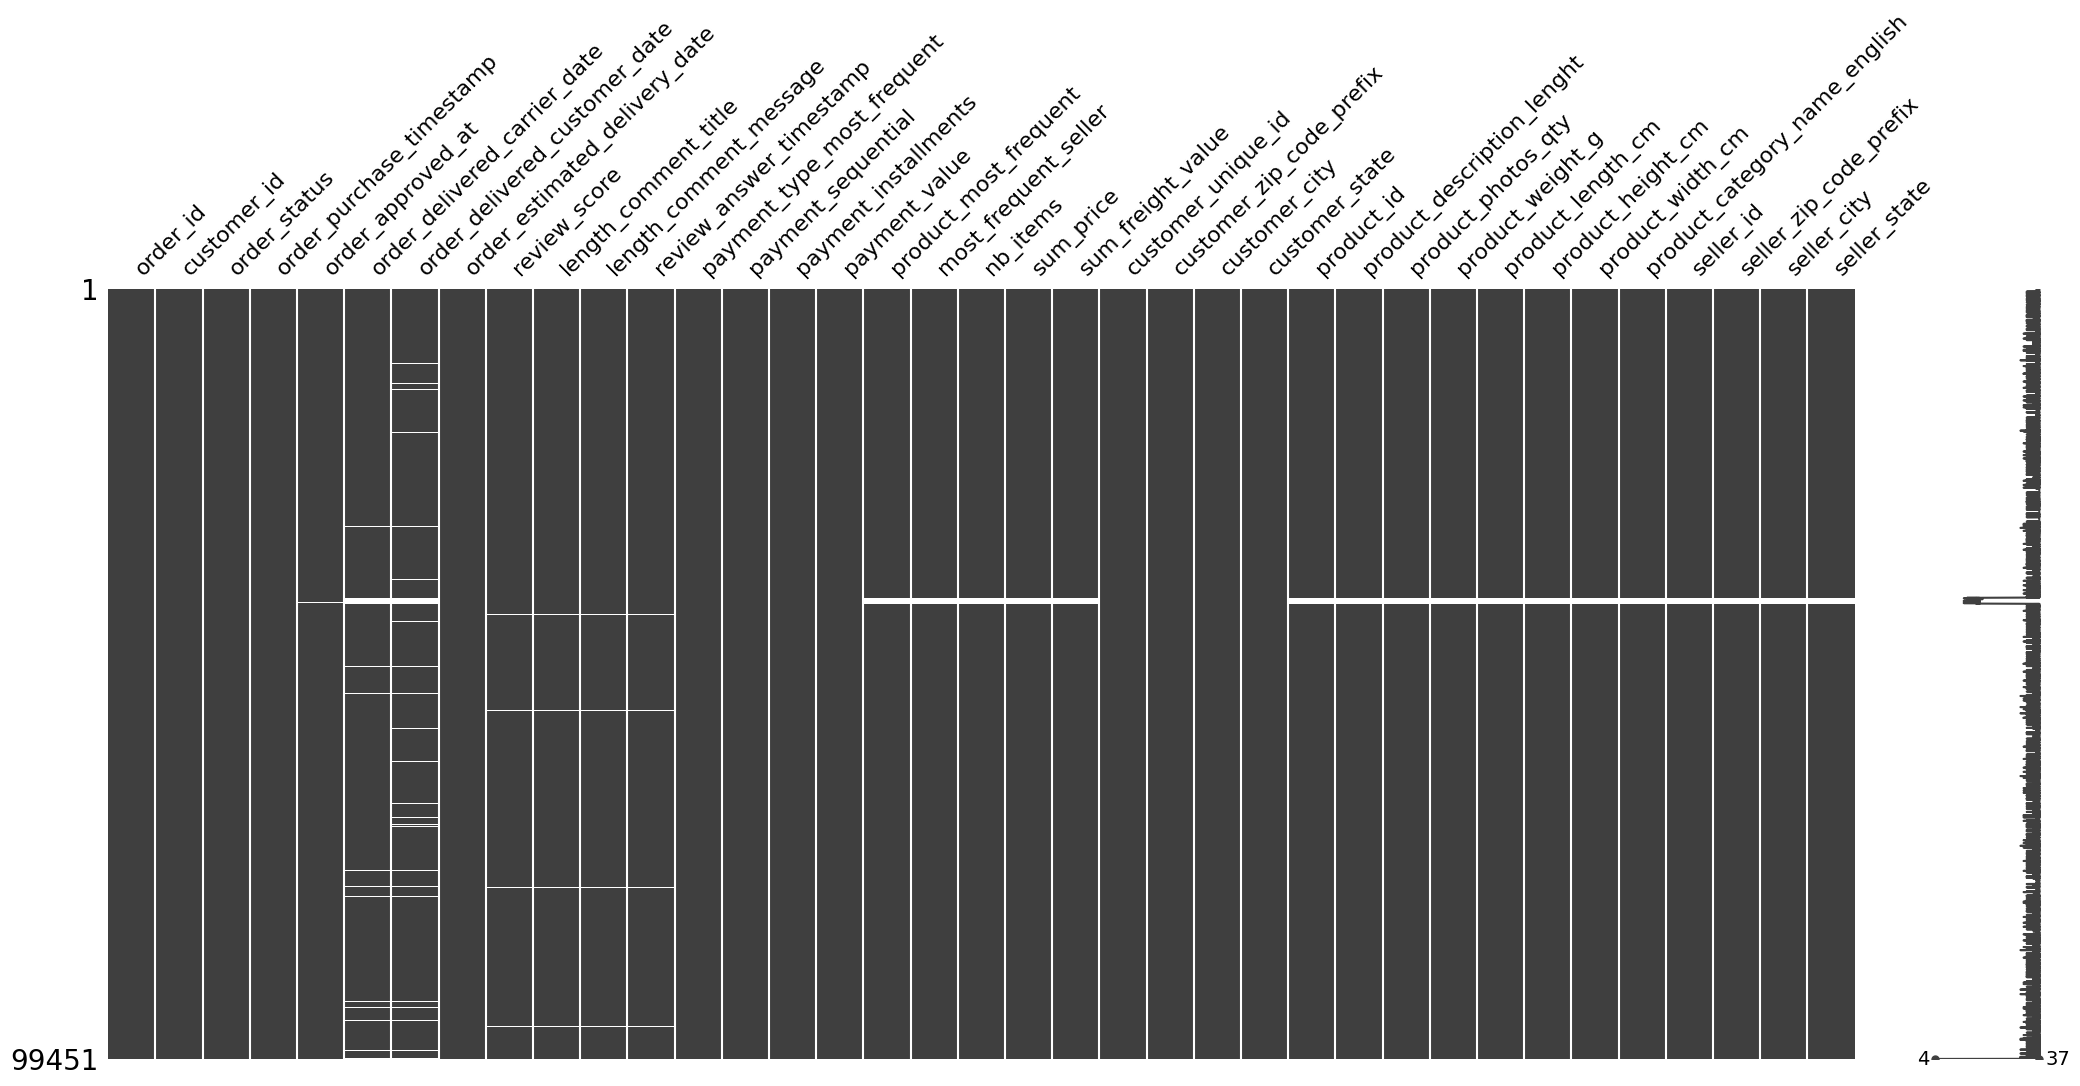

In [10]:
import missingno as msno

msno.matrix(df_merge)

In [11]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [12]:
num_columns = [col for col in df_merge.columns if df_merge[col].dtype != "object"]
cat_columns = [col for col in df_merge.columns if df_merge[col].dtype == "object"]
num_columns.remove("review_answer_timestamp")

TypeError: 'value' must be an instance of str or bytes, not a float

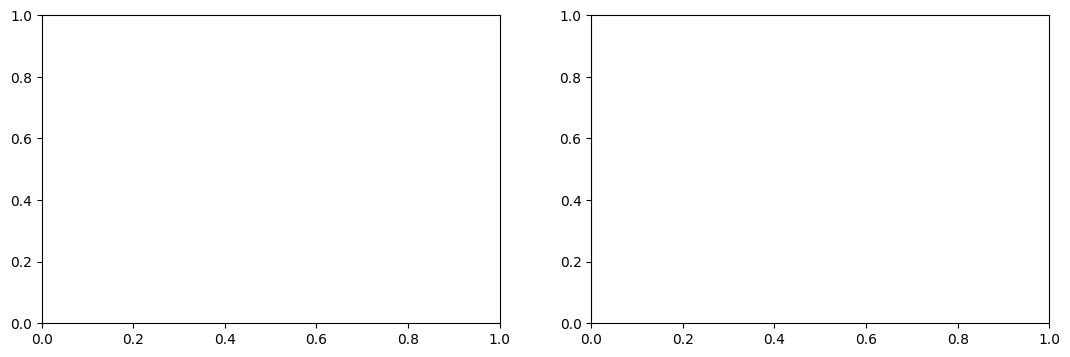

In [19]:
df_log = np.log1p(df_merge[num_columns])
liste_col = list(df_merge.columns)

for col in liste_col:
    # Création de la figure et des subplots
    fig, ax = plt.subplots(1,2, figsize=(13, 4))

    # Premier histogramme
    plt.hist(df_merge[col], kde=True)
    ax.set_title(f"Répartition  {col}\n (avant transformation)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    # Second histogramme
    plt.hist(df_log[col], kde=True)
    ax.set_title(f"Répartition {col}\n (après transformation)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    # Affichage de la figure
    plt.show()

In [ ]:
df_merge['order_status'].value_counts().to_frame()/len(df_merge)*100

,order_status
delivered,97.010588
shipped,1.113111
canceled,0.628450
unavailable,0.612362
invoiced,0.315733
processing,0.302662
created,0.005028
approved,0.002011


Nous ne conserverons que les order_statuts qui sont "delivered" car les autres catégories sont trop peu représentées

In [ ]:
df_merge = df_merge.loc[df_merge['order_status'] == "delivered"]